In [36]:
import os
import importlib
import matplotlib.pyplot as plt
import warnings
import sys

import numpy as np
import pandas as pd
import json
import joblib
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

import lightgbm as lgb
import cuml
base_FP = '/home/subin/data'
cpuserver_data_FP = '/home/subin/cpuserver_data'
print(base_FP)
print(cpuserver_data_FP)
sys.path.append(base_FP + '/python_modules')

import HydroAI.Plot as hPlot
import HydroAI.Shallow_ML as hSML

importlib.reload(hPlot);
importlib.reload(hSML);

save_path = f'Results'
if not os.path.exists(save_path):
    os.makedirs(save_path)

/home/subin/data
/home/subin/cpuserver_data


In [28]:
# Load the Iris dataset
from sklearn.datasets import load_iris
iris = load_iris()

print(iris.feature_names)
X_columns_list = ['sepal width (cm)', 'petal length (cm)', 'petal width (cm)']
X = pd.DataFrame(iris.data[:, 1:4], columns=X_columns_list)  # Features
y = pd.DataFrame(iris.data[:, [0]], columns=['sepal length (cm)'])  # Targets
print(np.shape(X))
print(np.shape(y))

# Random seed for reproducibility
seed = 0

['sepal length (cm)', 'sepal width (cm)', 'petal length (cm)', 'petal width (cm)']
(150, 3)
(150, 1)


In [19]:
# Set values for feature importance
feature_imp_X = X.values
feature_imp_y = y.values

# Standard scaling
scaler_X = StandardScaler()
scaler_y = StandardScaler()
feature_imp_X = scaler_X.fit_transform(feature_imp_X)
feature_imp_y = scaler_y.fit_transform(feature_imp_y.reshape(-1, 1)).flatten()

# Create dataframe for create_feature_importance_df
feature_imp_X_df = pd.DataFrame(data=feature_imp_X, columns=X_columns_list)

# Create feature importance dataframe
feature_imp = hSML.create_feature_importance_df(feature_imp_X_df, feature_imp_y)

feature_imp.head()

,feature,importance
0,petal length (cm),0.857794
1,sepal width (cm),0.077601
2,petal width (cm),0.064605


In [20]:
print(feature_imp)
np.shape(feature_imp_X_df)

             feature  importance
0  petal length (cm)    0.857794
1   sepal width (cm)    0.077601
2   petal width (cm)    0.064605


(150, 3)

In [26]:
# Rank threshold
top_rank_threshold = 2
feature_imp_list = list(feature_imp['feature'].head(top_rank_threshold).values)

print(feature_imp_list)

predictors = X[feature_imp_list].values
outcome = y['sepal length (cm)'].values

# Standard scaling for predictors & outcome
predictors_scaled = scaler_X.fit_transform(predictors)
outcome_scaled = scaler_y.fit_transform(outcome.reshape(-1, 1)).flatten()
print(np.shape(predictors_scaled), np.shape(outcome_scaled))

X_train, X_test, y_train, y_test = train_test_split(predictors_scaled, outcome_scaled, test_size=0.2, random_state=seed)

['petal length (cm)', 'sepal width (cm)']
(150, 2) (150,)


### LGBM

|   iter    |  target   | learni... | max_depth | n_esti... | num_le... |
-------------------------------------------------------------------------
| 1         | -0.2662   | 0.1692    | 9.437     | 200.7     | 90.83     |
| 2         | -0.2597   | 0.1329    | 8.813     | 159.4     | 135.9     |
| 3         | -0.2624   | 0.1826    | 8.856     | 158.2     | 136.4     |
| 4         | -0.2554   | 0.0864    | 8.772     | 160.5     | 135.5     |
| 5         | -0.2741   | 0.0119    | 8.706     | 162.3     | 134.7     |
| 6         | -0.2538   | 0.07255   | 8.217     | 160.4     | 136.1     |
| 7         | -0.2795   | 0.2994    | 7.404     | 160.0     | 135.2     |
| 8         | -0.284    | 0.01085   | 8.832     | 160.4     | 136.1     |
| 9         | -0.2777   | 0.2302    | 10.34     | 203.1     | 146.7     |
| 10        | -0.2575   | 0.09908   | 3.467     | 181.2     | 71.55     |
| 11        | -0.2918   | 0.299     | 10.47     | 235.5     | 93.78     |
| 12        | -0.2504   | 0.1829    | 

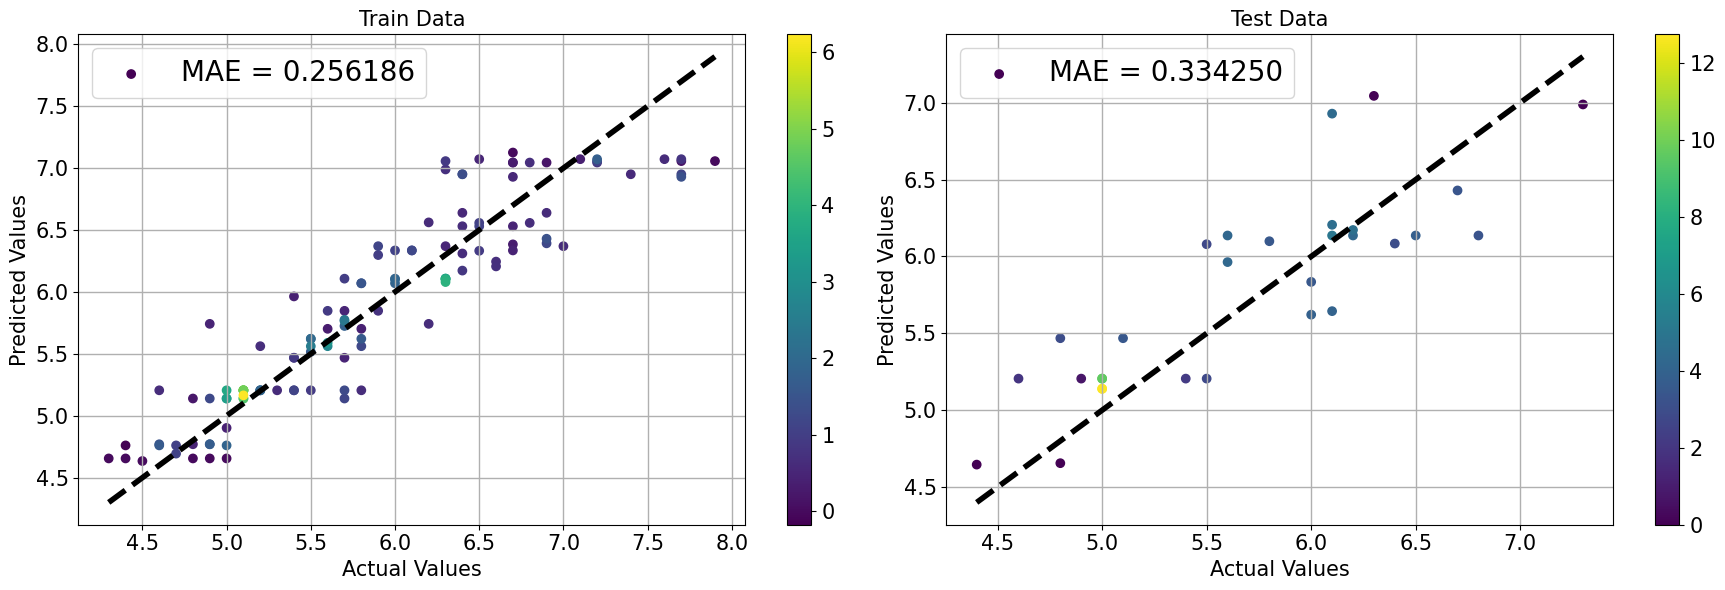

In [30]:
model_name = 'LGBM'

#Light GBM
score, best_params = hSML.Bayesian_optimization_LGBM(X_train, y_train,
                        pbounds = {
                                    'num_leaves': (20, 150),
                                    'max_depth': (3, 12),
                                    'learning_rate': (0.01, 0.3),
                                    'n_estimators': (50, 300)
                                }, n_iter=20)

with open(f'{save_path}/{model_name}_bayesian_best_params.json','w') as f:
    json.dump(best_params, f, ensure_ascii=False, indent=4)

model = lgb.LGBMRegressor(**best_params)
model.fit(X_train, y_train)

# Save the model
joblib.dump(model, f'{save_path}/{model_name}_model.pkl')

# Evaluate the model
relation_square = model.score(X_train, y_train)
print('Relation coefficient: ', relation_square)

y_pred_train = model.predict(X_train)
y_pred_test = model.predict(X_test)

# Inverse transform the predictions to get them back to the original scale
y_train_original = scaler_y.inverse_transform(y_train.reshape(-1, 1)).ravel()
y_test_original = scaler_y.inverse_transform(y_test.reshape(-1, 1)).ravel()
y_pred_train_original = scaler_y.inverse_transform(y_pred_train.reshape(-1, 1)).ravel()
y_pred_test_original = scaler_y.inverse_transform(y_pred_test.reshape(-1, 1)).ravel()

# Save pred & true dataframe
df_pred_true_train = pd.DataFrame({'y_true_train':y_train_original,
                                'y_pred_train':y_pred_train_original})
df_pred_true_train.to_csv(f'{save_path}/{model_name}_predtrue_train.csv', sep=',', index=False)

df_pred_true_test = pd.DataFrame({'y_true_test':y_test_original,
                                'y_pred_test':y_pred_test_original})
df_pred_true_test.to_csv(f'{save_path}/{model_name}_predtrue_test.csv', sep=',', index=False)

hPlot.plot_kde_scatter(y_train_original, y_pred_train_original, y_test_original, y_pred_test_original)

### RF

|   iter    |  target   | max_depth | max_fe... | min_sa... | n_esti... |
-------------------------------------------------------------------------
| 1         | -0.3604   | 55.33     | 0.743     | 30.93     | 277.0     |
| 2         | -0.279    | 42.94     | 0.6807    | 23.0      | 447.0     |
| 3         | -0.279    | 44.17     | 0.7018    | 23.3      | 447.3     |
| 4         | -0.6682   | 1.0       | 0.7657    | 31.54     | 10.0      |
| 5         | -0.5995   | 1.0       | 0.999     | 50.0      | 500.0     |
| 6         | -0.1937   | 61.47     | 0.1792    | 5.787     | 385.6     |
| 7         | -0.6043   | 1.0       | 0.999     | 50.0      | 359.8     |
| 8         | -0.1891   | 100.0     | 0.1       | 2.0       | 413.1     |
| 9         | -0.1881   | 100.0     | 0.1       | 2.0       | 338.9     |
| 10        | -0.1862   | 100.0     | 0.1       | 2.0       | 176.1     |
| 11        | -0.3734   | 1.693     | 0.1       | 2.0       | 174.1     |
| 12        | -0.4949   | 100.0     | 

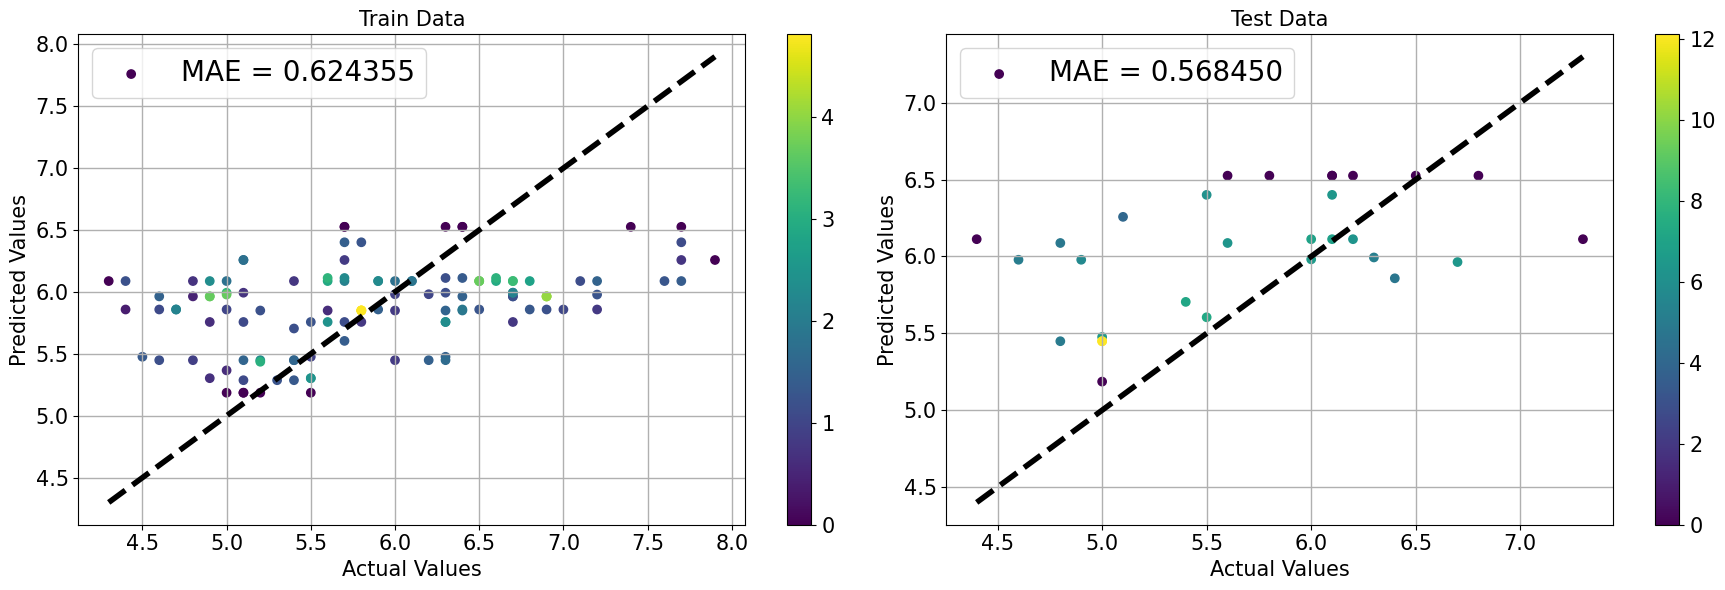

In [37]:
model_name = 'RF'
warnings.filterwarnings("ignore", message="The number of bins", category=UserWarning)
warnings.filterwarnings("ignore", message="To use pickling first train using float32 data to fit the estimator", category=UserWarning)

score, best_params = hSML.Bayesian_optimization_RF(X_train, y_train,
                        pbounds={
                                'n_estimators': (10, 500),
                                'max_features': (0.1, 0.999),
                                'max_depth': (1, 100),
                                'min_samples_split': (2, 50)
                            }, n_iter=20) #, library_model='RF_cuml') # RF_cuml is for GPU

with open(f'{save_path}/{model_name}_bayesian_best_params.json','w') as f:
    json.dump(best_params, f, ensure_ascii=False, indent=4)

model = cuRF(**best_params, n_streams=1) # For reproducible (n_streams)
model.fit(X_train, y_train)

# Save the model
joblib.dump(model, f'{save_path}/{model_name}_model.pkl')

relation_square = model.score(X_train, y_train)
print('relation coefficient : ', relation_square)

y_pred_train = model.predict(X_train)
y_pred_test = model.predict(X_test)

# Inverse transform the predictions to get them back to the original scale
y_train_original = scaler_y.inverse_transform(y_train.reshape(-1, 1)).ravel()
y_test_original = scaler_y.inverse_transform(y_test.reshape(-1, 1)).ravel()
y_pred_train_original = scaler_y.inverse_transform(y_pred_train.reshape(-1, 1)).ravel()
y_pred_test_original = scaler_y.inverse_transform(y_pred_test.reshape(-1, 1)).ravel()

# Save pred & true dataframe
df_pred_true_train = pd.DataFrame({'y_true_train':y_train_original,
                                'y_pred_train':y_pred_train_original})
df_pred_true_train.to_csv(f'{save_path}/{model_name}_predtrue_train.csv', sep=',', index=False)

df_pred_true_test = pd.DataFrame({'y_true_test':y_test_original,
                                'y_pred_test':y_pred_test_original})
df_pred_true_test.to_csv(f'{save_path}/{model_name}_predtrue_test.csv', sep=',', index=False)

hPlot.plot_kde_scatter(y_train_original, y_pred_train_original, y_test_original, y_pred_test_original)

### XGB

|   iter    |  target   | colsam... | max_depth | min_ch... | n_esti... |
-------------------------------------------------------------------------


/home/subin/miniconda3/envs/cuml_env/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [10:40:55] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost-split_1722454208151/work/src/common/error_msg.cc:58: Falling back to prediction using DMatrix due to mismatched devices. This might lead to higher memory usage and slower performance. XGBoost is running on: cuda:0, while the input data is on: cpu.
Potential solutions:
- Use a data structure that matches the device ordinal in the booster.
- Set the device for booster before call to inplace_predict.

This warning will only be shown once.

  warnings.warn(smsg, UserWarning)


| 1         | -0.5827   | 0.5934    | 71.8      | 30.93     | 277.0     |
| 2         | -0.533    | 0.4809    | 64.94     | 23.0      | 447.0     |
| 3         | -0.533    | 0.7829    | 65.57     | 22.56     | 445.9     |
| 4         | -0.4227   | 0.8745    | 1.0       | 3.155     | 10.0      |
| 5         | -0.7219   | 0.999     | 100.0     | 50.0      | 10.0      |
| 6         | -0.198    | 0.1       | 1.0       | 2.0       | 63.12     |
| 7         | -0.1976   | 0.1       | 1.0       | 2.0       | 110.6     |
| 8         | -0.7219   | 0.1       | 1.0       | 50.0      | 93.8      |
| 9         | -0.1994   | 0.999     | 24.74     | 2.0       | 86.81     |
| 10        | -0.1992   | 0.1       | 39.27     | 2.0       | 138.1     |
| 11        | -0.198    | 0.999     | 1.0       | 2.0       | 177.2     |
| 12        | -0.1992   | 0.999     | 100.0     | 2.0       | 166.0     |
| 13        | -0.1992   | 0.1       | 100.0     | 2.0       | 110.8     |
| 14        | -0.7219   | 0.1       | 

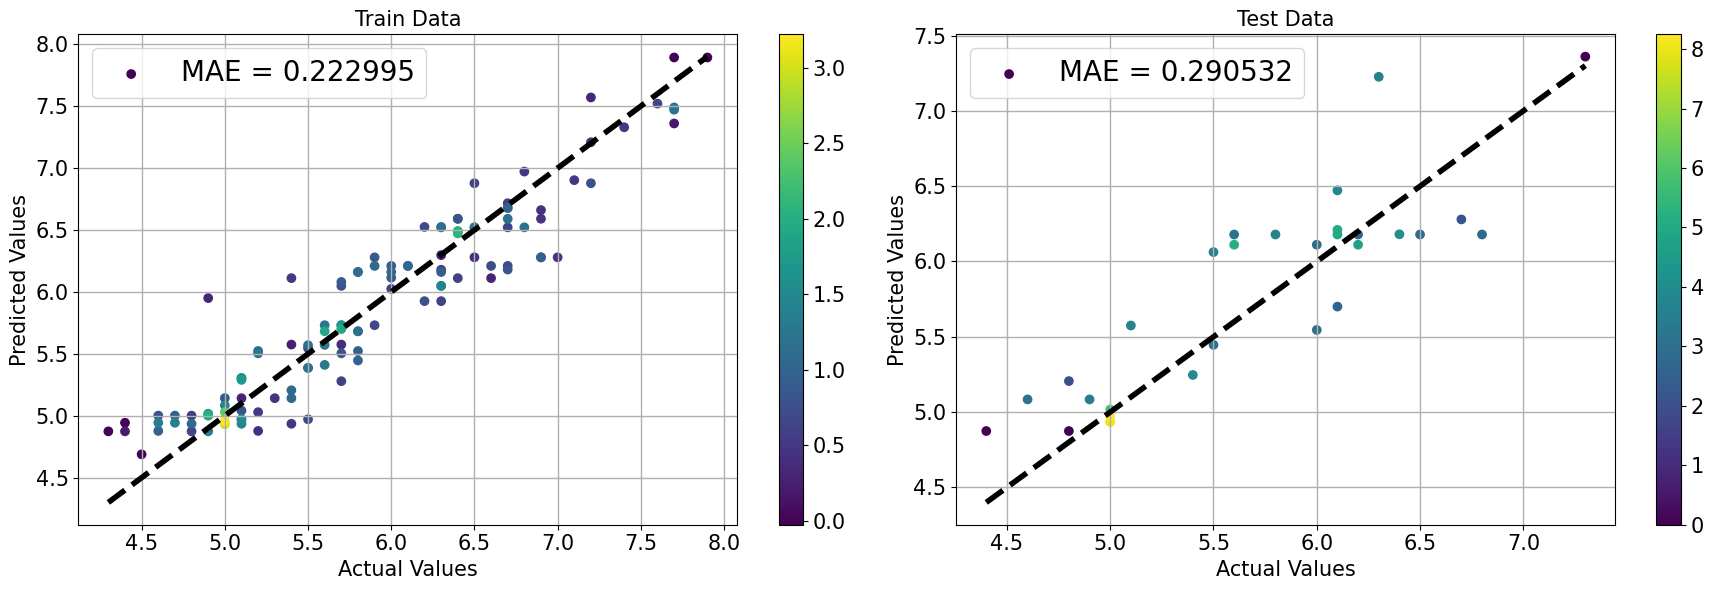

In [32]:
model_name = 'XGB'

# CuPy: CuPy is a GPU array library that is highly compatible with NumPy, making it easy to convert CPU-based NumPy arrays to GPU arrays.
#X_train = cp.array(X_train)
score, best_params = hSML.Bayesian_optimization_XGB(X_train, y_train,
                      pbounds={
                          'n_estimators': (10, 500),
                          'colsample_bytree': (0.1, 0.999),
                          'max_depth': (1, 100),
                          'min_child_weight': (2, 50)
                      }, n_iter=20)

with open(f'{save_path}/{model_name}_bayesian_best_params.json','w') as f:
    json.dump(best_params, f, ensure_ascii=False, indent=4)

model = xgb.XGBRegressor(**best_params)
model.fit(X_train, y_train)

# Save the model
joblib.dump(model, f'{save_path}/{model_name}_model.pkl')

relation_square = model.score(X_train, y_train)
print('relation coefficient : ', relation_square)

y_pred_train = model.predict(X_train)
y_pred_test = model.predict(X_test)

# Inverse transform the predictions to get them back to the original scale
y_train_original = scaler_y.inverse_transform(y_train.reshape(-1, 1)).ravel()
y_test_original = scaler_y.inverse_transform(y_test.reshape(-1, 1)).ravel()
y_pred_train_original = scaler_y.inverse_transform(y_pred_train.reshape(-1, 1)).ravel()
y_pred_test_original = scaler_y.inverse_transform(y_pred_test.reshape(-1, 1)).ravel()

# Save pred & true dataframe
df_pred_true_train = pd.DataFrame({'y_true_train':y_train_original,
                                'y_pred_train':y_pred_train_original})
df_pred_true_train.to_csv(f'{save_path}/{model_name}_predtrue_train.csv', sep=',', index=False)

df_pred_true_test = pd.DataFrame({'y_true_test':y_test_original,
                                'y_pred_test':y_pred_test_original})
df_pred_true_test.to_csv(f'{save_path}/{model_name}_predtrue_test.csv', sep=',', index=False)

hPlot.plot_kde_scatter(y_train_original, y_pred_train_original, y_test_original, y_pred_test_original)

### SVM

|   iter    |  target   |     C     |  degree   |  epsilon  |   gamma   |
-------------------------------------------------------------------------
| 1         | -0.2146   | 54.93     | 4.146     | 0.6067    | 0.5494    |
| 2         | -0.2012   | 42.42     | 3.938     | 0.4432    | 0.8929    |
| 3         | -0.1919   | 52.21     | 3.573     | 0.534     | 0.4801    |
| 4         | -0.1847   | 72.69     | 2.603     | 0.253     | 0.1913    |
| 5         | -0.3963   | 0.1471    | 3.845     | 0.6135    | 0.6731    |
| 6         | -0.1512   | 90.32     | 2.0       | 0.01      | 0.01      |
| 7         | -0.3734   | 100.0     | 5.0       | 1.0       | 1.0       |
| 8         | -0.1519   | 83.0      | 2.0       | 0.01      | 0.01      |
| 9         | -0.2811   | 26.76     | 2.0       | 1.0       | 0.01      |
| 10        | -0.3734   | 86.58     | 5.0       | 1.0       | 1.0       |
| 11        | -0.151    | 91.87     | 2.0       | 0.01      | 0.01      |
| 12        | -0.1519   | 80.06     | 

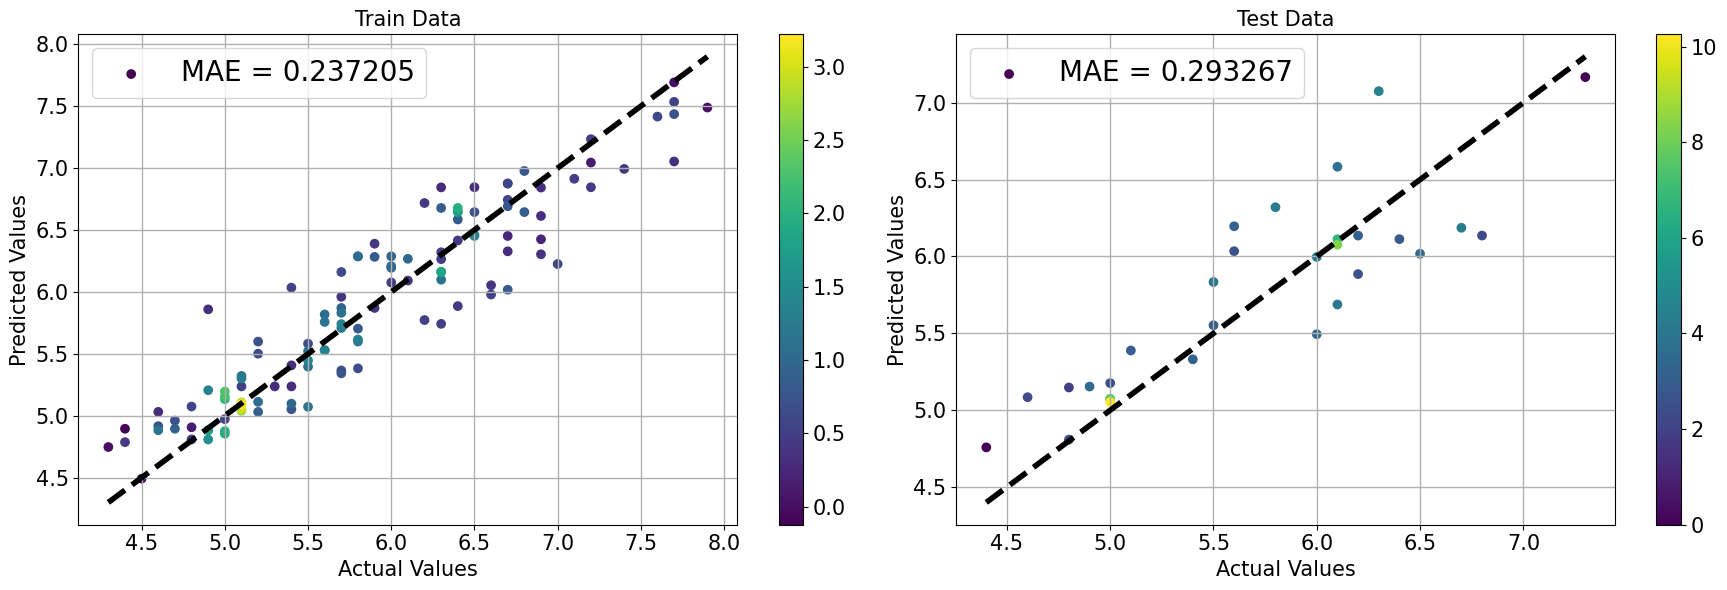

In [34]:
model_name = 'SVM'

score, best_params = hSML.Bayesian_optimization_SVM(X_train, y_train,
                        pbounds = {
                                    'C': (0.1, 100),
                                    'epsilon': (0.01, 1),
                                    'gamma': (0.01, 1),
                                    'degree': (2, 5)  # Only used if kernel is 'poly'
                                }, n_iter=20, library_model='SVM_cuml') # SVM_cuml is for GPU (24.09.30 -> scikit-learn SVM is not prepared)

with open(f'{save_path}/{model_name}_bayesian_best_params.json','w') as f:
    json.dump(best_params, f, ensure_ascii=False, indent=4)

model = SVR(**best_params)
model.fit(X_train, y_train)

# Save the model
joblib.dump(model, f'{save_path}/{model_name}_model.pkl')

relation_square = model.score(X_train, y_train)
print('relation coefficient : ', relation_square)

y_pred_train = model.predict(X_train)
y_pred_test = model.predict(X_test)

# Inverse transform the predictions to get them back to the original scale
y_train_original = scaler_y.inverse_transform(y_train.reshape(-1, 1)).ravel()
y_test_original = scaler_y.inverse_transform(y_test.reshape(-1, 1)).ravel()
y_pred_train_original = scaler_y.inverse_transform(y_pred_train.reshape(-1, 1)).ravel()
y_pred_test_original = scaler_y.inverse_transform(y_pred_test.reshape(-1, 1)).ravel()

# Save pred & true dataframe
df_pred_true_train = pd.DataFrame({'y_true_train':y_train_original,
                                'y_pred_train':y_pred_train_original})
df_pred_true_train.to_csv(f'{save_path}/{model_name}_predtrue_train.csv', sep=',', index=False)

df_pred_true_test = pd.DataFrame({'y_true_test':y_test_original,
                                'y_pred_test':y_pred_test_original})
df_pred_true_test.to_csv(f'{save_path}/{model_name}_predtrue_test.csv', sep=',', index=False)

hPlot.plot_kde_scatter(y_train_original, y_pred_train_original, y_test_original, y_pred_test_original)